
Spatial Transformer Networks Tutorial
=====================================
**Author**: `Ghassen HAMROUNI <https://github.com/GHamrouni>`_

.. figure:: /_static/img/stn/FSeq.png

In this tutorial, you will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the `DeepMind paper <https://arxiv.org/abs/1506.02025>`__

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [1]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data
----------------

In this post we experiment with the classic MNIST dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_dir = '/mnt/d/Datasets'

class Dataset(torch.utils.data.Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.data = datasets.MNIST(root=root_dir, train=True, download=True)
        self.transform = transforms.Compose([
            transforms.RandomAffine((10, 30), translate=(0.1, 0.2), scale=(0.5, 1.0), shear=None),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))                                        
        ])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx][0]
        return self.transform(item), self.target_transform(item)

Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:: /_static/img/stn/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners = True)
        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        return x


model = Net().to(device)

Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [4]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
dataset = Dataset()
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        criterion = nn.MSELoss()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

for epoch in range(1, 30 + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.094848
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.027150
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.584767
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.537804
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.458166
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.430277
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.410281
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.405140
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.381338
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.395311
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.417583
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.365846
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.382792
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.343289
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.350691
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.346285
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.320750
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.348801
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.354622
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.360656
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.291249
Tr

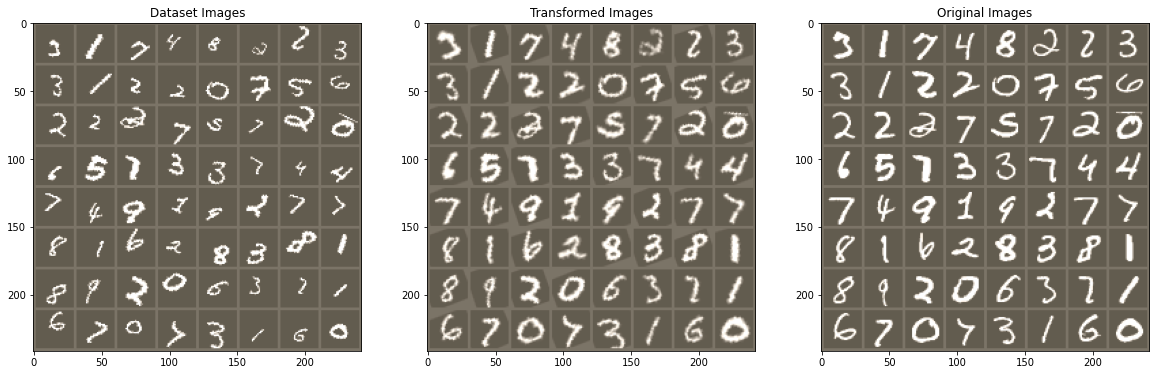

In [6]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data, target = next(iter(train_loader))
        data = data.to(device)
        transformed_input = model(data).cpu()
        data = data.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(data))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input))

        orig_grid = convert_image_np(
            torchvision.utils.make_grid(target)
        )

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 3, figsize = (20, 20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

        axarr[2].imshow(orig_grid)
        axarr[2].set_title('Original Images')

visualize_stn()

In [7]:
torch.save(model.state_dict(), 'mnist-spatial-transformer.pt')